In [1]:
import os
import shutil
from pathlib import Path
import urllib

from astropy.io import fits
import astropy.coordinates as coord
import astropy.table as at
from astropy.constants import G
from astropy.time import Time
import astropy.units as u
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm.notebook import tqdm
import thejoker as tj
import tables as tb
from astropy.timeseries import BoxLeastSquares

import hq.config
hq.config.HQ_CACHE_PATH = '/mnt/home/apricewhelan/projects/hq/cache'

from hq.config import Config, HQ_CACHE_PATH
from hq.data import get_rvdata
from hq.samples_analysis import extract_MAP_sample

import lightkurve as lk

from pyia import GaiaData

In [2]:
def fast_mf(P, K, e):
    """Binary mass function."""
    mf_circ = P * K**3 / (2*np.pi * G)
    return mf_circ.to(u.Msun) * (1 - e**2)**1.5

from twobody.transforms import get_m2_min

In [3]:
c = Config.from_run_name('dr17-beta-202010')

In [4]:
# allstar = at.Table.read(c.allstar_filename)
# allstar = at.Table.read('/mnt/home/apricewhelan/data/APOGEE_beta/allStarLite-r13-l33-58932beta.fits')
allstar = at.Table.read('/mnt/home/apricewhelan/data/APOGEE_DR17/allStar-dr17-l33alpha.fits')
allvisit = at.Table.read(c.allvisit_filename)

allstar_dr16 = at.Table.read('/mnt/home/apricewhelan/data/APOGEE_DR16/allStarLite-r12-l33.fits')
allvisit_dr16 = at.Table.read('/mnt/home/apricewhelan/data/APOGEE_DR16/allVisit-r12-l33.fits')

In [5]:
metadata = at.QTable.read(c.metadata_joker_path)

metadata = at.join(metadata, allstar, keys='APOGEE_ID')
metadata = metadata[np.unique(metadata['APOGEE_ID'], return_index=True)[1]]
len(metadata)

271248

In [7]:
row = metadata[metadata['APOGEE_ID'] == '2M19241171+3650235'][0]
row_c = coord.SkyCoord(row['RA'], row['DEC'], unit='deg')

In [8]:
visits = allvisit[allvisit['APOGEE_ID'] == row['APOGEE_ID']]
visits_dr16 = allvisit_dr16[allvisit_dr16['APOGEE_ID'] == row['APOGEE_ID']]

In [9]:
row['J'], row['H'], row['GAIA_PHOT_G_MEAN_MAG']

(10.457, 10.096, 12.395216)

In [11]:
row['TEFF'], row['LOGG'], row['M_H'], row['VSINI']

(5253.268, 4.567548, 0.195301, 7.04758)

In [14]:
row['FIELD']

'K21_071+10'

In [18]:
visits['PLATE', 'MJD', 'FIBERID', 'SNR']

PLATE,MJD,FIBERID,SNR
bytes16,int32,int16,float32
6912,56367,104,66.7092
8580,57471,117,74.746
8631,57498,105,20.4919
8631,57554,118,69.7163
8580,57831,105,81.494
7561,57701,100,75.4026
8580,57199,106,61.4402
8631,57850,118,80.0672
8630,57562,99,85.6451


In [197]:
# root_url = "https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/visit/"
# cache_path = Path('tmp')
# cache_path.mkdir(exist_ok=True)

# for v in visits:
#     sub_path = f"{v['TELESCOPE']}/{v['FIELD'].strip()}/{v['PLATE'].strip()}/{v['MJD']}"
#     filename = f"apVisit-r12-{v['PLATE'].strip()}-{int(v['MJD']):05d}-{int(v['FIBERID']):03d}.fits"
#     url = os.path.join(root_url, sub_path, filename)
#     local_path = cache_path / filename
#     if not local_path.exists():
#         urllib.request.urlretrieve(url, local_path)

def get_apStar(r):
    root_url = "https://data.sdss.org/sas/dr16/apogee/spectro/aspcap/r12/l33/"
    cache_path = Path('tmp')
    cache_path.mkdir(exist_ok=True)

    sub_path = f"{r['TELESCOPE']}/{r['FIELD'].strip()}"
    filename = f"aspcapStar-r12-{r['APOGEE_ID'].strip()}.fits"
    url = os.path.join(root_url, sub_path, filename)
    print(url)
    local_path = cache_path / filename
    if not local_path.exists():
        urllib.request.urlretrieve(url, local_path)
        
    return fits.open(local_path)

In [198]:
tbl = allstar_dr16
close_mask = (
    (np.abs(row['M_H'] - tbl['M_H']) < 0.1) &
    (np.abs(row['LOGG'] - tbl['LOGG']) < 0.1) &
    (np.abs(row['TEFF'] - tbl['TEFF']) < 100) &
    (np.abs(row['SNR'] - tbl['SNR']) < 30) &
    (tbl['APOGEE_ID'] != row['APOGEE_ID'])
)
compare_row = tbl[close_mask][0]
close_mask.sum()

1

In [199]:
apstar1 = get_apStar(row)
apstar_compare = get_apStar(compare_row)

https://data.sdss.org/sas/dr16/apogee/spectro/aspcap/r12/l33/apo25m/K21_071+10/aspcapStar-r12-2M19241171+3650235.fits
https://data.sdss.org/sas/dr16/apogee/spectro/aspcap/r12/l33/apo25m/174+33_MGA/aspcapStar-r12-2M08145030+4550227.fits


(4400, 4800)

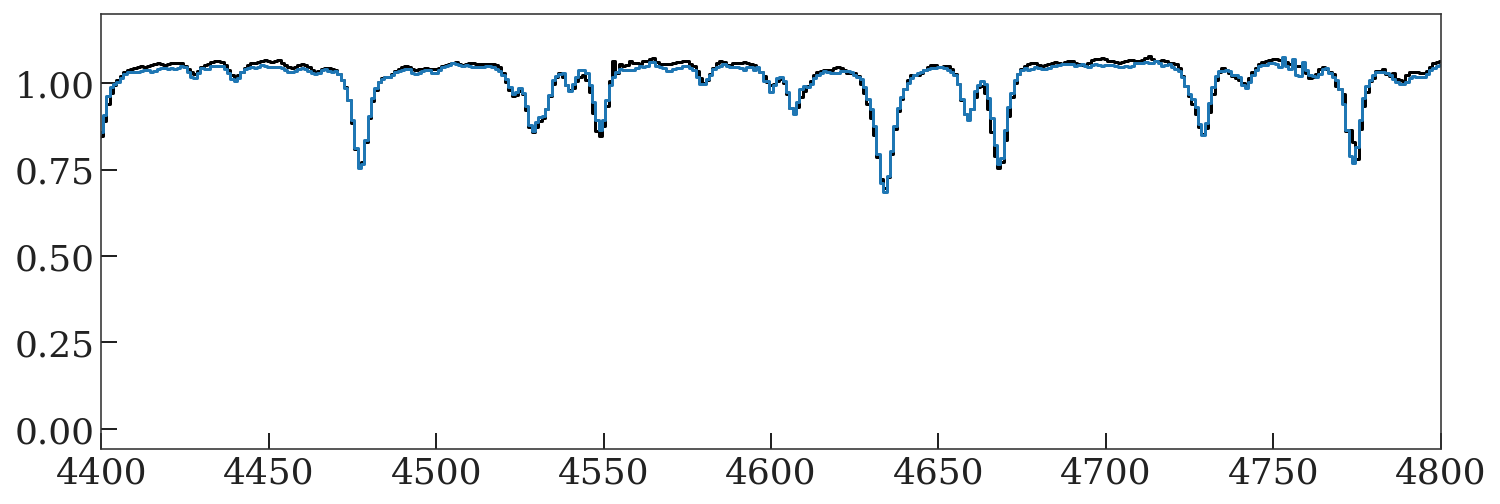

In [207]:
plt.figure(figsize=(12, 4))
plt.plot(apstar1[1].data, marker='', drawstyle='steps-mid')
plt.plot(apstar_compare[1].data, marker='', drawstyle='steps-mid')
# plt.xlim(4000, 4400)
plt.xlim(4400, 4800)

# APOGEE

In [184]:
from hq.physics_helpers import stellar_radius

In [192]:
R1 = stellar_radius(row['LOGG'], row['mass']*u.Msun) 
df = 0.0015
np.sqrt(df) * R1.to(u.Rjup), np.sqrt(df) * R1.to(u.Rearth)

(<Quantity 0.28607891 jupiterRad>, <Quantity 3.20665297 earthRad>)

In [157]:
data = get_rvdata(visits)
data_dr16 = get_rvdata(visits_dr16)

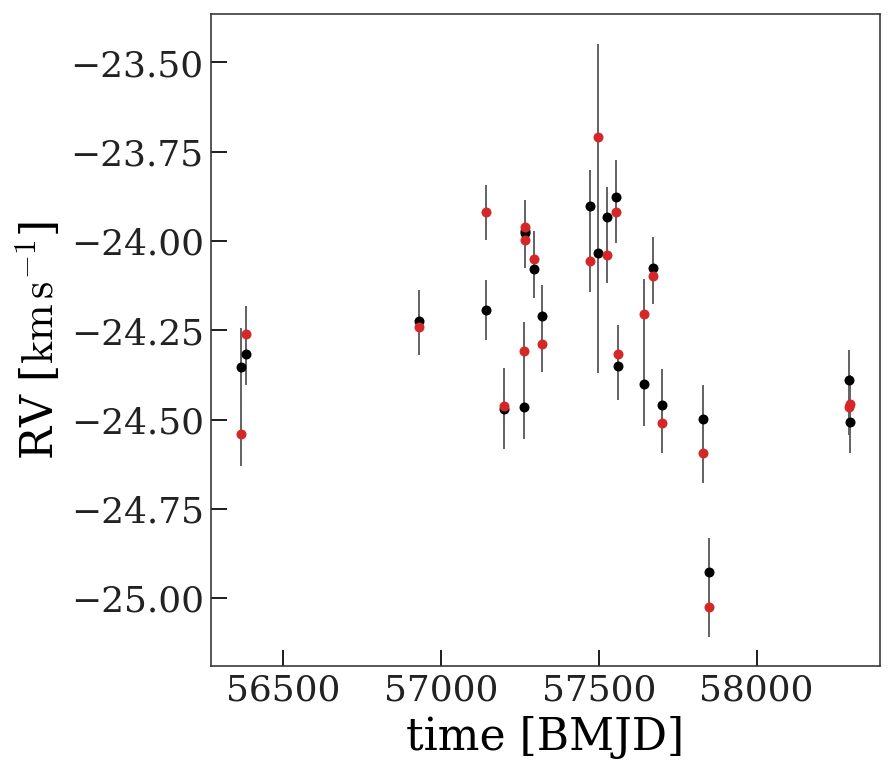

In [159]:
data.plot()
data_dr16.plot(color='tab:red')

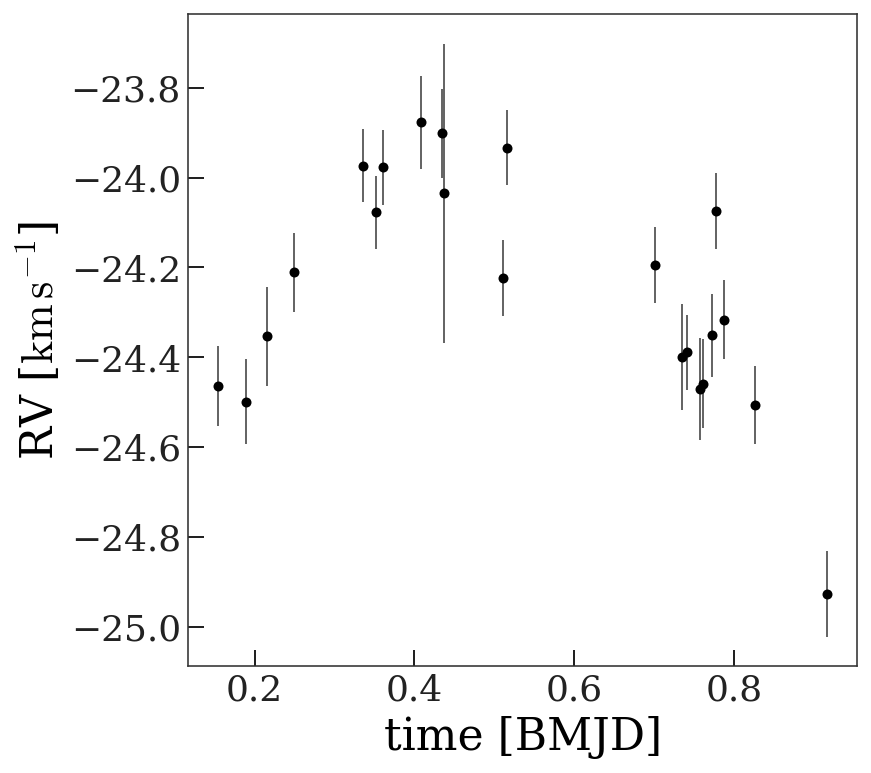

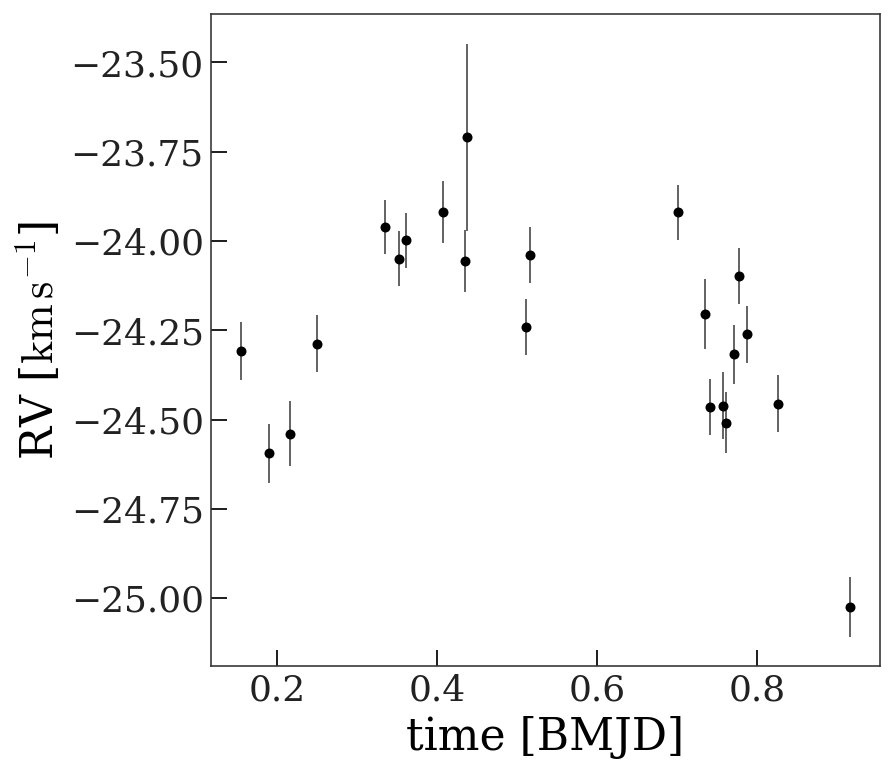

In [160]:
_ = data.plot(phase_fold=row['MAP_P'])

plt.figure()
_ = data_dr16.plot(phase_fold=row['MAP_P'])

In [69]:
row

APOGEE_ID,MAP_K,MAP_M0,MAP_P,MAP_e,MAP_ln_likelihood,MAP_ln_prior,MAP_omega,MAP_s,MAP_v0,baseline,constant_ln_evidence,joker_completed,kepler_ln_evidence,max_phase_gap,max_unmarginalized_ln_likelihood,n_visits,periods_spanned,phase_coverage,phase_coverage_per_period,t0_bmjd,unimodal,constant_ln_likelihood,robust_constant_ln_likelihood,robust_success,FILE,TELESCOPE,LOCATION_ID,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,H,H_ERR,K,K_ERR,SRC_H,WASH_M,WASH_M_ERR,WASH_T2,WASH_T2_ERR,DDO51,DDO51_ERR,IRAC_3_6,IRAC_3_6_ERR,IRAC_4_5,IRAC_4_5_ERR,IRAC_5_8,IRAC_5_8_ERR,WISE_4_5,WISE_4_5_ERR,TARG_4_5,TARG_4_5_ERR,WASH_DDO51_GIANT_FLAG,WASH_DDO51_STAR_FLAG,TARG_PMRA,TARG_PMDEC,TARG_PM_SRC,AK_TARG,AK_TARG_METHOD,AK_WISE,SFD_EBV,APOGEE_TARGET1,APOGEE_TARGET2,APOGEE_TARGET3,APOGEE2_TARGET1,APOGEE2_TARGET2,APOGEE2_TARGET3,APOGEE2_TARGET4,TARGFLAGS,SURVEY,PROGRAMNAME,NINST,NVISITS,COMBTYPE,COMMISS,SNR,STARFLAG,STARFLAGS,ANDFLAG,ANDFLAGS,VHELIO_AVG,VSCATTER,VERR,RV_TEFF,RV_LOGG,RV_FEH,RV_ALPHA,RV_CARB,RV_CCPFWHM,RV_AUTOFWHM,N_COMPONENTS,MEANFIB,SIGFIB,GAIA_SOURCE_ID,GAIA_PARALLAX,GAIA_PARALLAX_ERROR,GAIA_PMRA,GAIA_PMRA_ERROR,GAIA_PMDEC,GAIA_PMDEC_ERROR,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,GAIA_A_G_VAL,GAIA_E_BP_MIN_RP_VAL,GAIA_RADIAL_VELOCITY,GAIA_RADIAL_VELOCITY_ERROR,GAIA_R_EST,GAIA_R_LO,GAIA_R_HI
,km / s,rad,d,,,,rad,km / s,km / s,d,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bytes30,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,int64,float64,float64,int64,float64,bool,float64,float64,bool,bytes64,bytes6,int64,bytes20,bytes30,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,bytes16,float64,bytes32,float64,float64,int64,int64,int64,int64,int64,int64,int64,bytes132,bytes16,bytes32,int64,int64,int64,int64,float64,int64,bytes132,int64,bytes132,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64
2M19241171+3650235,0.6052446289246752,-0.986491858959198,0.9631649255752563,0.28861284255981445,-3.0700190207183535,4.187852836529409,-2.733807325363159,0.10211310535669327,-24.3793287103643,1927.8818330248978,-52.739161988021806,False,0.12392524559996954,0.2382966499981194,14.597851596193676,22,2001.6113355387697,0.9,1,56367.508142644554,True,-48.81908414636681,-3.8487187414131174,True,apStar-r14-2M19241171+3650235.fits,apo25m,4589,K21_071+10,none,291.048799,36.839882,69.40566484678183,9.900797039554005,10.456999778747559,0.023000000044703484,10.095999717712402,0.02500000037252903,10.015999794006348,0.020999999716877937,2MASS,-9999.990234375,-9999.990234375,-9999.990234375,-9999.990234375,-9999.990234375,-9999.990234375,-9999.990234375,-9999.990234375,-9999.990234375,-9999.990234375,-9999.990234375,-9999.990234375,9.913999557495117,0.019999999552965164,9.913999557495117,0.019999999552965164,-1,1,11.0,18.0,KIC,0.12117614597082138,RJCE_WISE,0.12117614597082138,0.20470023155212402,-1879048192,0,0,0,0,-2147483647,0,"APOGEE_KEPLER_HOSTAPOGEE2_KOI,APOGEE2_","apogee2-manga,ap","kep_koi,apogee",0,22,0,0,592.6123593606159,-9223372036854773760,PERSIST_LOW,-9223372036854775808,,-24.241566794315876,0.25966169367728154,0.0,5555.220449009866,4.887403069956142,0.18711329483727257,0.0,0.0,0.0,0.0,1,109.04621887207031,13.293962435234922,2050249406650364160,4.272821357545681,0.023465181134968708,1.4411612031464982,0.04160116682162287,7.835637992510339,0.05000458165224895,12.395216,12.604887,11.571988,-9999.0,-9999.0,-23.089651806682696,2.38807249232558,232.472397304746,231.201573506683,233.757017327482


In [113]:
# with tb.open_file(c.mcmc_results_path, mode='r') as mcmc_f:
samples = tj.JokerSamples.read(c.joker_results_path,
                               f"/{row['APOGEE_ID']}/samples")

In [118]:
samples['K']

<Quantity [0.49551484, 0.60524463, 0.40703557] km / s>

---
# Gaia sources nearby

In [9]:
row_c

<SkyCoord (ICRS): (ra, dec) in deg
    (291.048799, 36.839882)>

In [10]:
nearby_cmd_g = GaiaData.from_query(f"""
SELECT TOP 10000 ra, dec, parallax, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag
FROM gaiaedr3.gaia_source 
WHERE parallax_over_error > 8 AND
    1 = CONTAINS(
        POINT('ICRS', ra, dec),
        CIRCLE('ICRS', {row_c.ra.degree}, {row_c.dec.degree}, 4.)
    )""")
len(nearby_cmd_g)

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
INFO: Query finished. [astroquery.utils.tap.core]


10000

In [11]:
search_radius = 10*u.arcsec
q = f"""
SELECT *,
    3600 * DISTANCE(
        POINT('ICRS', ra, dec),
        POINT('ICRS', {row_c.ra.degree}, {row_c.dec.degree})
    ) AS dist, dr2_radial_velocity as radial_velocity, dr2_radial_velocity_error as radial_velocity_error
FROM gaiaedr3.gaia_source 
WHERE
    1 = CONTAINS(
        POINT('ICRS', ra, dec),
        CIRCLE('ICRS', {row_c.ra.degree}, {row_c.dec.degree}, {search_radius.to_value(u.deg)})
    )
ORDER BY dist ASC
"""
g = GaiaData.from_query(q)

INFO: Query finished. [astroquery.utils.tap.core]


In [12]:
g.radial_velocity

<Quantity [-23.089651,        nan,        nan] km / s>

In [13]:
g.radial_velocity_error

<Quantity [2.3880725,       nan,       nan] km / s>

In [112]:
g.phot_g_mean_mag

<Quantity [12.391208, 12.476327, 19.477633] mag>

In [113]:
g.phot_bp_mean_mag

<Quantity [12.702691, 12.786491, 18.568214] mag>

In [114]:
g.phot_rp_mean_mag

<Quantity [11.570021, 11.346934, 17.641685] mag>

In [22]:
near_c = g.get_skycoord()
c_pair = g[g.dist < 1.5].get_skycoord()

In [23]:
c_pair[1].separation(c_pair[0])

<Angle 0.00048643 deg>

In [94]:
pair_g = g[:2]

n_samples = 1000
err_g = pair_g.get_error_samples(size=n_samples)
err_c_samples = err_g.get_skycoord(radial_velocity=0*u.km/u.s)

sep3d_samples = err_c_samples[0].separation_3d(err_c_samples[1])
np.mean(sep3d_samples.to_value(u.pc)), np.std(sep3d_samples.to_value(u.pc))

(8.308650259191916, 1.0971664507442875)

In [ ]:
vtan_samples = err_g.vtan.reshape(n_samples, 2, 2)
dvtan = np.sqrt(np.sum((vtan_samples[..., 0] - vtan_samples[..., 1])**2, axis=1))
np.mean(dvtan), np.std(dvtan)

In [24]:
offset_frame = coord.SkyOffsetFrame(origin=row_c)

In [25]:
# near_c_past = near_c.apply_space_motion(dt=-18*u.year)

In [26]:
near_c_off = near_c.transform_to(offset_frame)

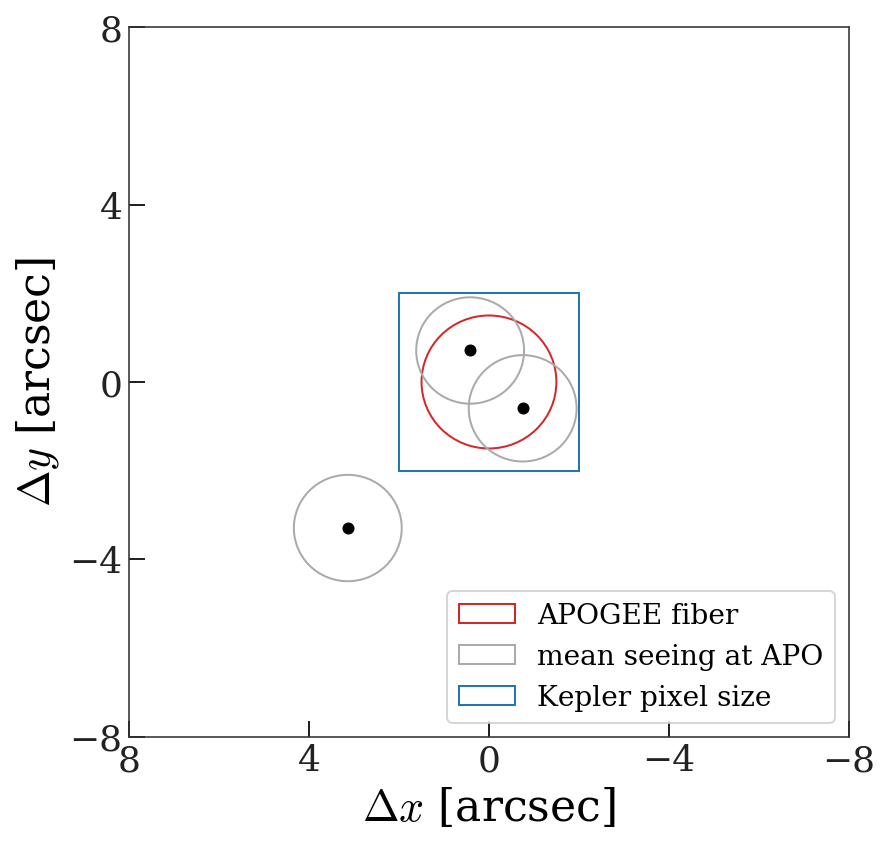

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(6.3, 6))
ax.scatter(near_c_off.lon.arcsec, near_c_off.lat.arcsec)
ax.add_patch(mpl.patches.Circle((0,0), radius=1.5, 
                                facecolor='none', edgecolor='tab:red',
                                label='APOGEE fiber'))

for i, src in enumerate(near_c_off):
    label = None
    if i == 0:
        label = 'mean seeing at APO'
    ax.add_patch(mpl.patches.Circle((src.lon.arcsec, src.lat.arcsec), radius=1.2, 
                                    facecolor='none', edgecolor='#aaaaaa',
                                    label=label))
    
ax.add_patch(mpl.patches.Rectangle(
    (-2, -2), width=4, height=4,
    facecolor='none', edgecolor='tab:blue',
    label='Kepler pixel size'))

ax.set_xlabel(r'$\Delta x$ [arcsec]')
ax.set_ylabel(r'$\Delta y$ [arcsec]')

ax.set_xticks(np.arange(-8, 8+1, 4))
ax.set_yticks(np.arange(-8, 8+1, 4))

ax.set_xlim(8, -8)
ax.set_ylim(-8, 8)

ax.legend(loc='lower right', fontsize=14)

fig.tight_layout()
fig.set_facecolor('w')

In [94]:
c_pair[1].separation_3d(c_pair[0])

<Distance 2.39196449 pc>

In [95]:
np.sqrt((c_pair[1].pm_ra_cosdec - c_pair[0].pm_ra_cosdec)**2 +
        (c_pair[1].pm_dec - c_pair[0].pm_dec)**2)

<Quantity 0.47948531 mas / yr>

In [96]:
c_pair

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    [(291.048944  , 36.84007836, 234.03739972),
     (291.04853857, 36.83971594, 236.42936338)]
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(1.4411612 , 7.83563799, -23.08965181),
     (1.33166283, 8.30245302,          nan)]>

In [119]:
g.phot_g_mean_mag - g.distmod

<Quantity [5.57067763, 5.57878804, 7.36764833] mag>

In [137]:
bprp_err = np.sqrt((1/g.phot_bp_mean_flux_over_error)**2 + 
                   (1/g.phot_rp_mean_flux_over_error)**2)
g_err = 1 / g.phot_g_mean_flux_over_error
bprp_err, g_err

(<MaskedColumn name='phot_bp_mean_flux_over_error' dtype='float32' length=3>
  0.03277547
 0.024437154
  0.14893192,
 <MaskedColumn name='phot_g_mean_flux_over_error' dtype='float32' length=3>
  0.000738077
 0.0009681637
 0.0051599247)

In [141]:
g.phot_bp_rp_excess_factor

1.4411287
1.7361661
3.9593


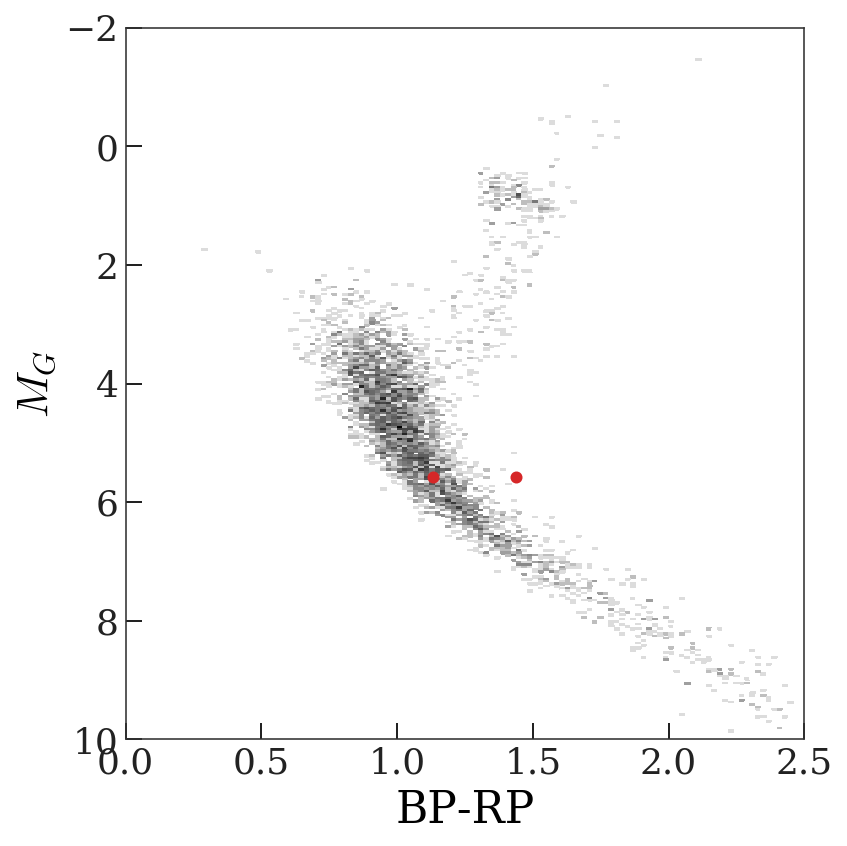

In [65]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist2d((nearby_cmd_g.phot_bp_mean_mag - nearby_cmd_g.phot_rp_mean_mag).value,
          (nearby_cmd_g.phot_g_mean_mag - nearby_cmd_g.distmod).value,
          bins=(np.arange(0, 2.5, 0.02),
                np.arange(-2, 10, 0.04)),
          norm=mpl.colors.LogNorm(),
          cmap='Greys')
ax.scatter((g.phot_bp_mean_mag - g.phot_rp_mean_mag).value[:2],
           (g.phot_g_mean_mag - g.distmod).value[:2], 
           color='tab:red')
ax.set_xlim(0, 2.5)
ax.set_ylim(10, -2)
ax.set_xlabel('BP-RP')
ax.set_ylabel('$M_G$')
fig.set_facecolor('w')
fig.tight_layout()

In [146]:
g.ruwe

1.2988303
1.4481497
1.0017748


In [108]:
g.vtan[1] - g.vtan[0]

<Quantity [-0.23326083,  0.93135737] km / s>

---

# lightkurve'n away

In [33]:
result = lk.search_lightcurvefile(coord.SkyCoord(row['RA'], row['DEC'], unit='deg'), 
                                  mission='Kepler').download_all()
# result = lk.search_lightcurvefile('KIC 2707097', cadence='long').download_all()
result

/mnt/home/apricewhelan/anaconda3/envs/hq/lib/python3.7/site-packages/lightkurve/lightcurvefile.py:47: LightkurveWarning: `LightCurveFile.header` is deprecated, please use `LightCurveFile.get_header()` instead.
  LightkurveWarning)


LightCurveFileCollection of 18 objects:
	KIC 1161345 (18 KeplerLightCurveFiles) Quarters: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17

In [215]:
tess_result = lk.search_lightcurvefile(coord.SkyCoord(row['RA'], row['DEC'], unit='deg'), 
                                       mission='TESS').download_all()

/mnt/home/apricewhelan/anaconda3/envs/hq/lib/python3.7/site-packages/lightkurve/lightcurvefile.py:47: LightkurveWarning: `LightCurveFile.header` is deprecated, please use `LightCurveFile.get_header()` instead.
  LightkurveWarning)


In [34]:
row['APOGEE_ID']

'2M19241171+3650235'

In [35]:
stitched_lc = result.PDCSAP_FLUX.stitch()
stitched_lc = stitched_lc[stitched_lc.quality == 0]
stitched_lc = stitched_lc[np.isfinite(stitched_lc.flux)]
stitched_lc = stitched_lc.remove_outliers()
stitched_lc = stitched_lc[:-5000]

In [227]:
tess_lc = tess_result.PDCSAP_FLUX.stitch()

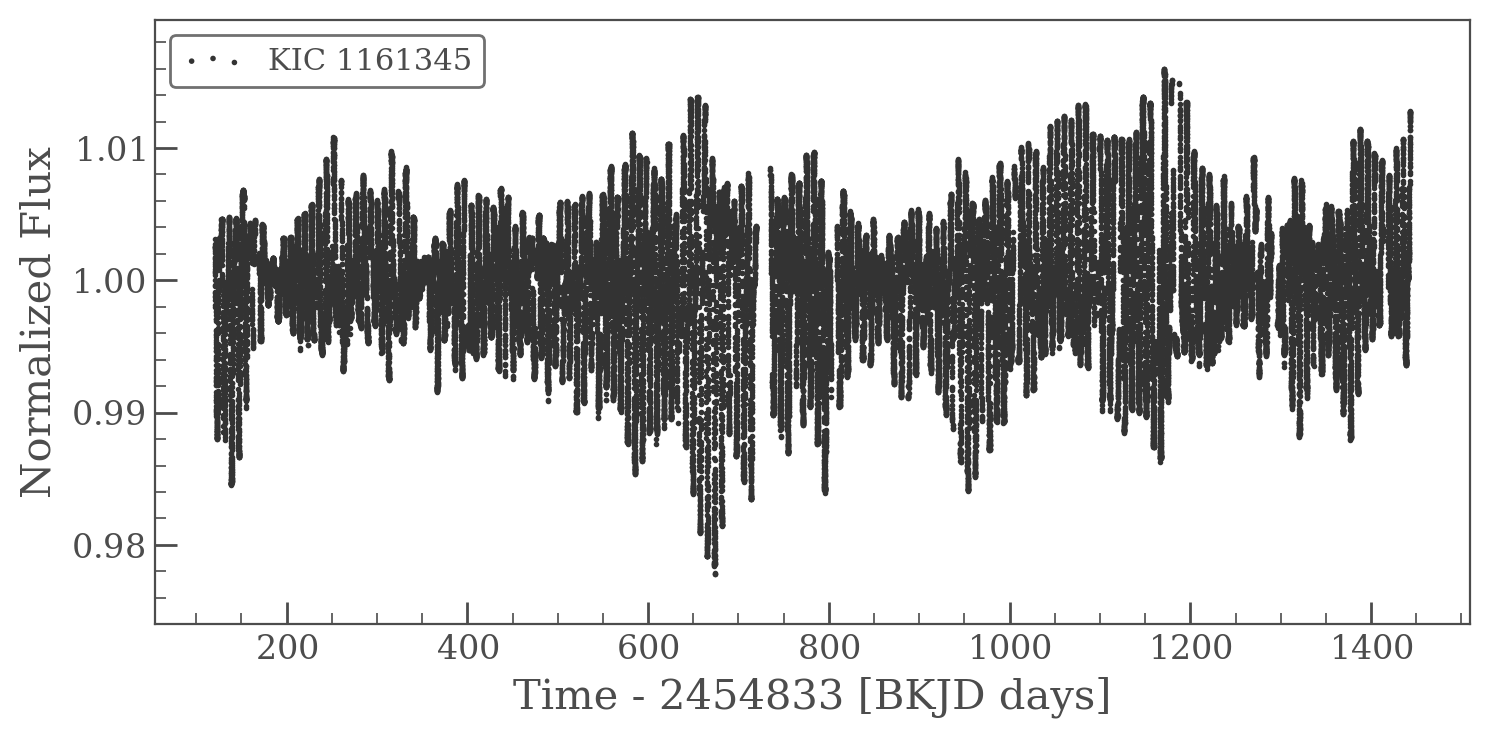

In [36]:
stitched_lc.scatter()

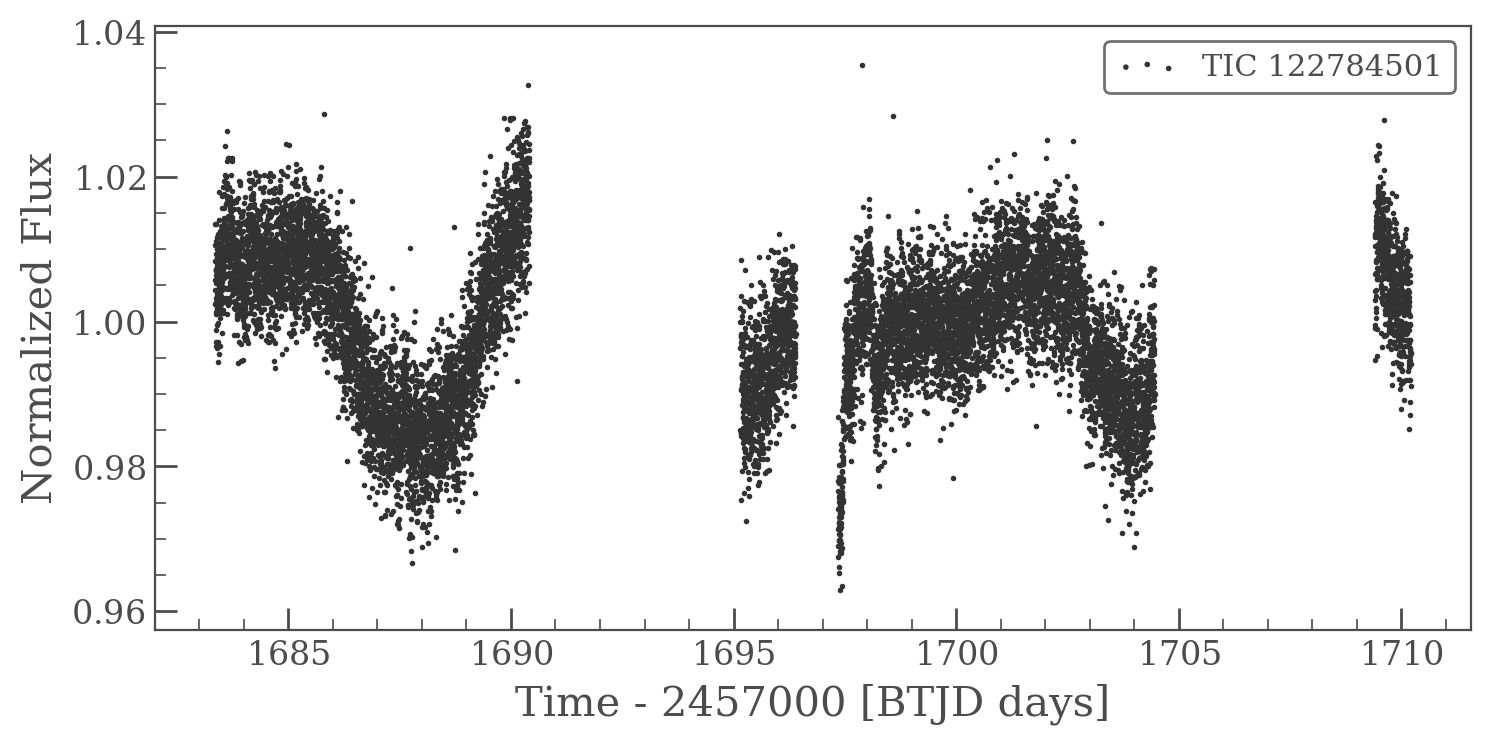

In [228]:
tess_lc.scatter()

In [37]:
# stitched_lc.fold(row['MAP_P']).scatter()

In [38]:
# bls = BoxLeastSquares(stitched_lc.time, stitched_lc.flux, stitched_lc.flux_err)

fl_lc = stitched_lc.flatten().flatten()
bls = BoxLeastSquares(fl_lc.time, fl_lc.flux, fl_lc.flux_err)

# Pgrid = np.clip(np.linspace(0.1, 10, 2048*8) * row['MAP_P'].value, 0.1, np.inf)
# bls_res = bls.power(Pgrid, duration=[0.01, 0.04, 0.08])

Pgrid = np.linspace(4., 4.8, 4096*4)
bls_res = bls.power(Pgrid, duration=[0.08, 0.09, 0.1])
# 4.288 from eyeballing

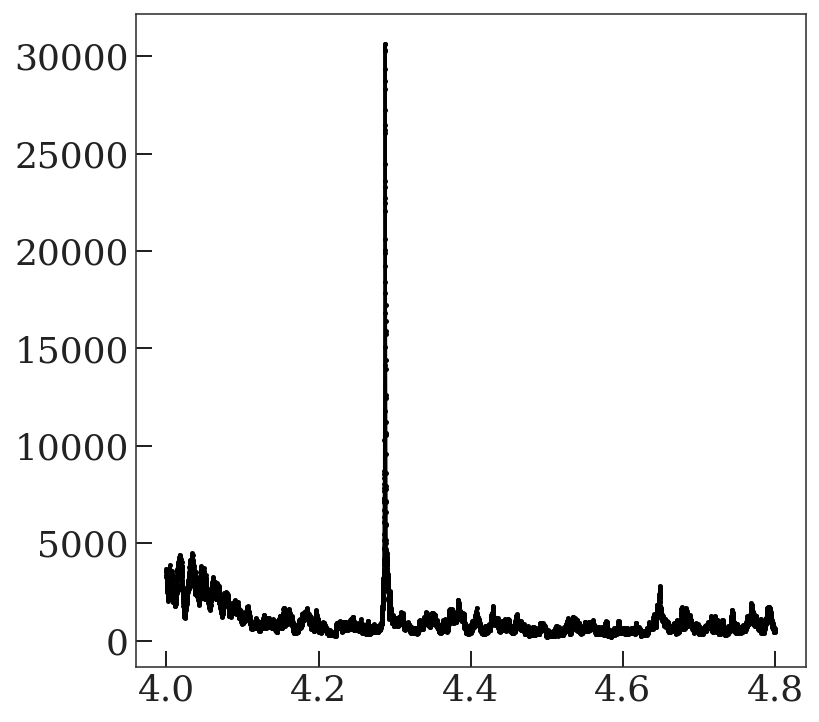

In [39]:
plt.plot(Pgrid, bls_res.power)

In [40]:
best = np.argmax(bls_res.power)
period = bls_res.period[best]
transit_time = bls_res.transit_time[best]
duration = bls_res.duration[best]
period, transit_time, duration

(4.287468717573094, 120.5833125217306, 0.088)

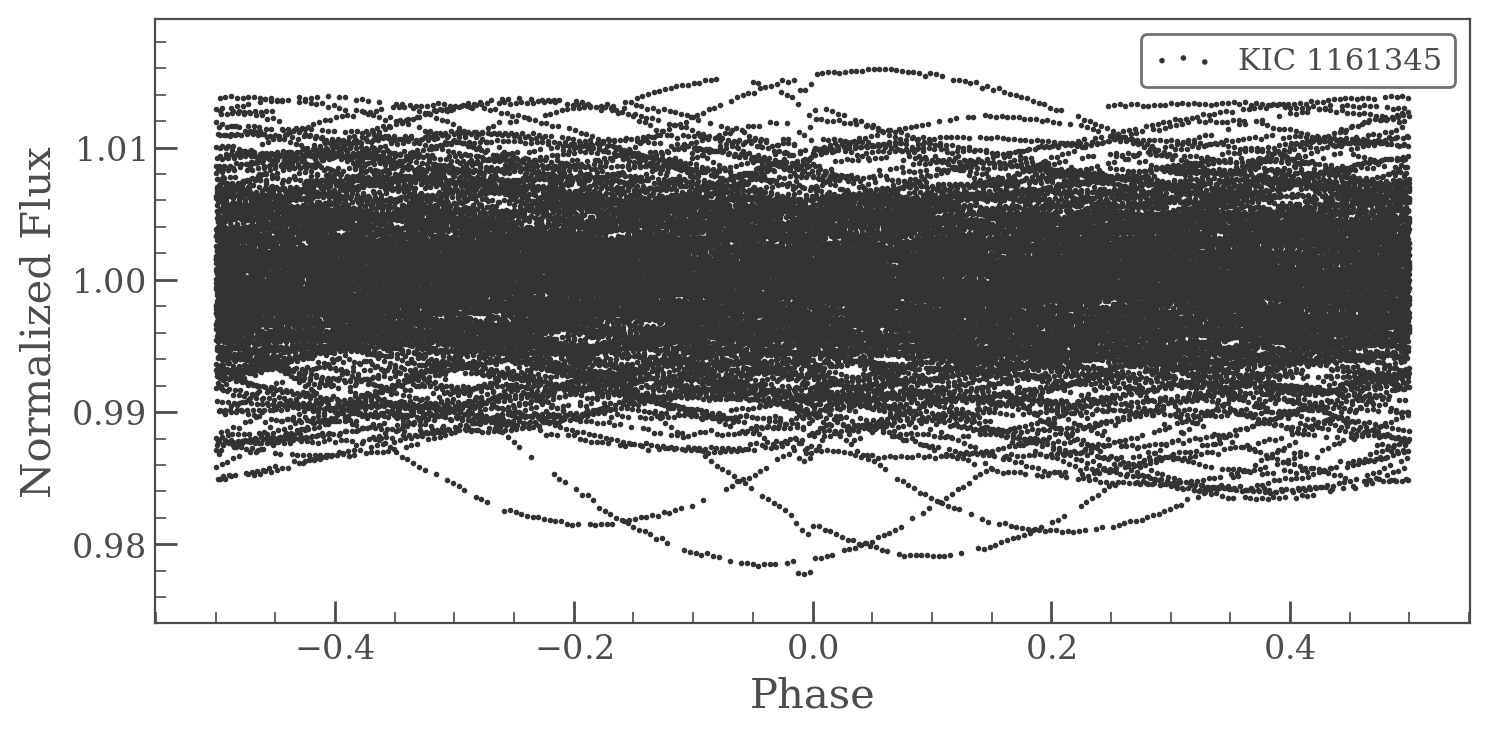

In [41]:
stitched_lc.fold(period, t0=transit_time).scatter()

In [42]:
# stitched_lc.flatten().flatten().flatten().plot()
# # plt.xlim(270, 280)
# plt.xlim(274, 276)
# plt.ylim(0.996, 1.004)

# plt.axvline(270.645)
# plt.axvline(274.933)

In [43]:
period

4.287468717573094

(0.995, 1.005)

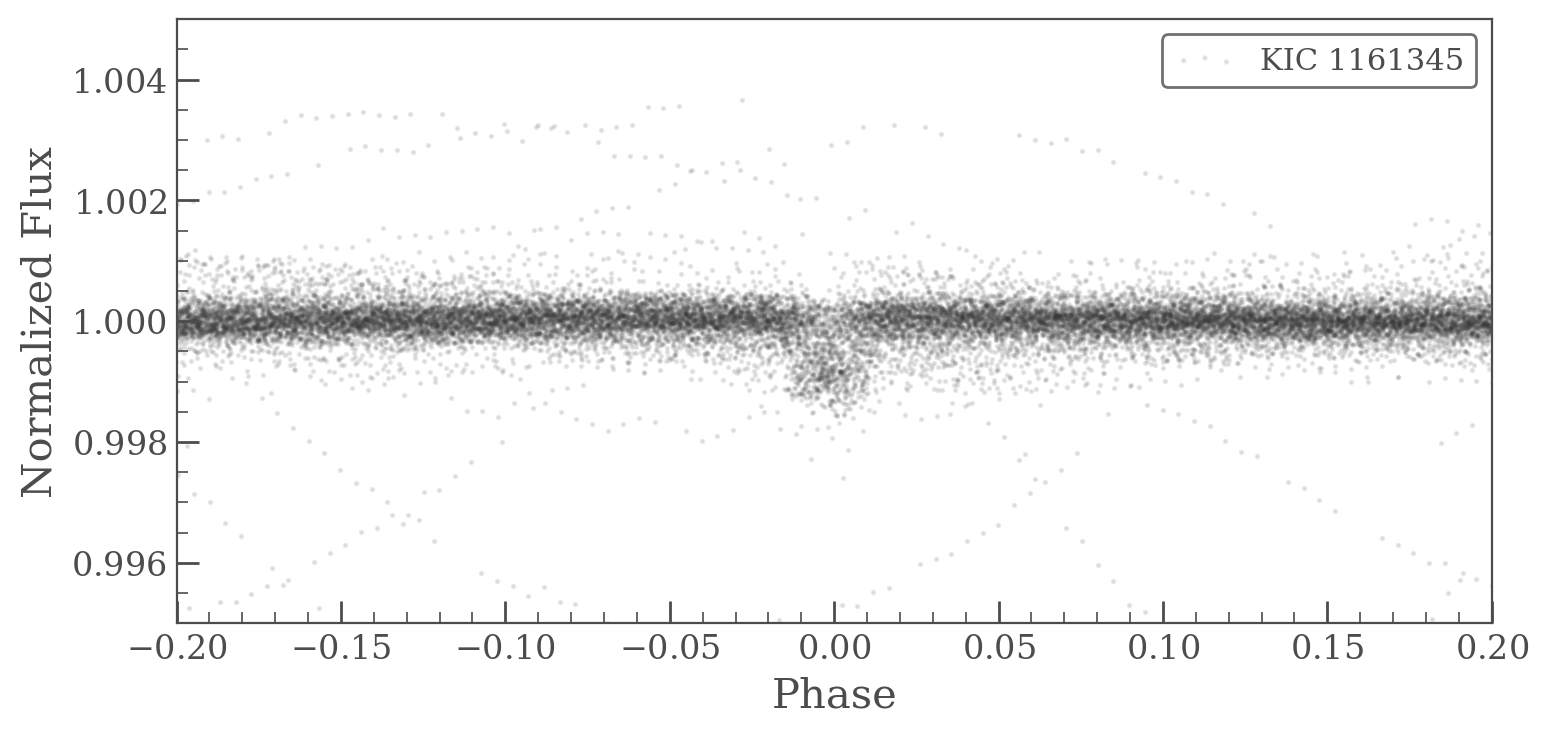

In [44]:
stitched_lc.flatten().fold(period, t0=transit_time).scatter(alpha=0.1)
plt.xlim(-0.2, 0.2)
plt.ylim(0.995, 1.005)

In [46]:
folded = stitched_lc.flatten().fold(period, t0=transit_time)

In [64]:
period

4.287468717573094

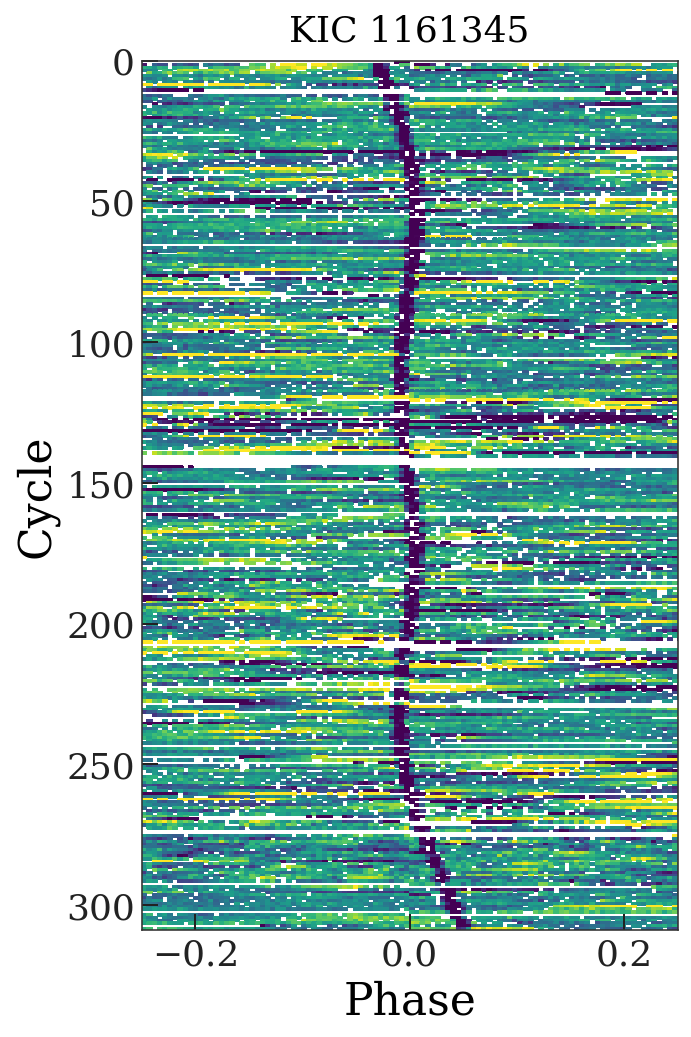

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(6, 8))
axes = folded.plot_river(ax=ax)
axes.set_xlim(-0.25, 0.25)

fig = axes.get_figure()
fig.axes[1].set_visible(False)

ax.set_aspect('auto')

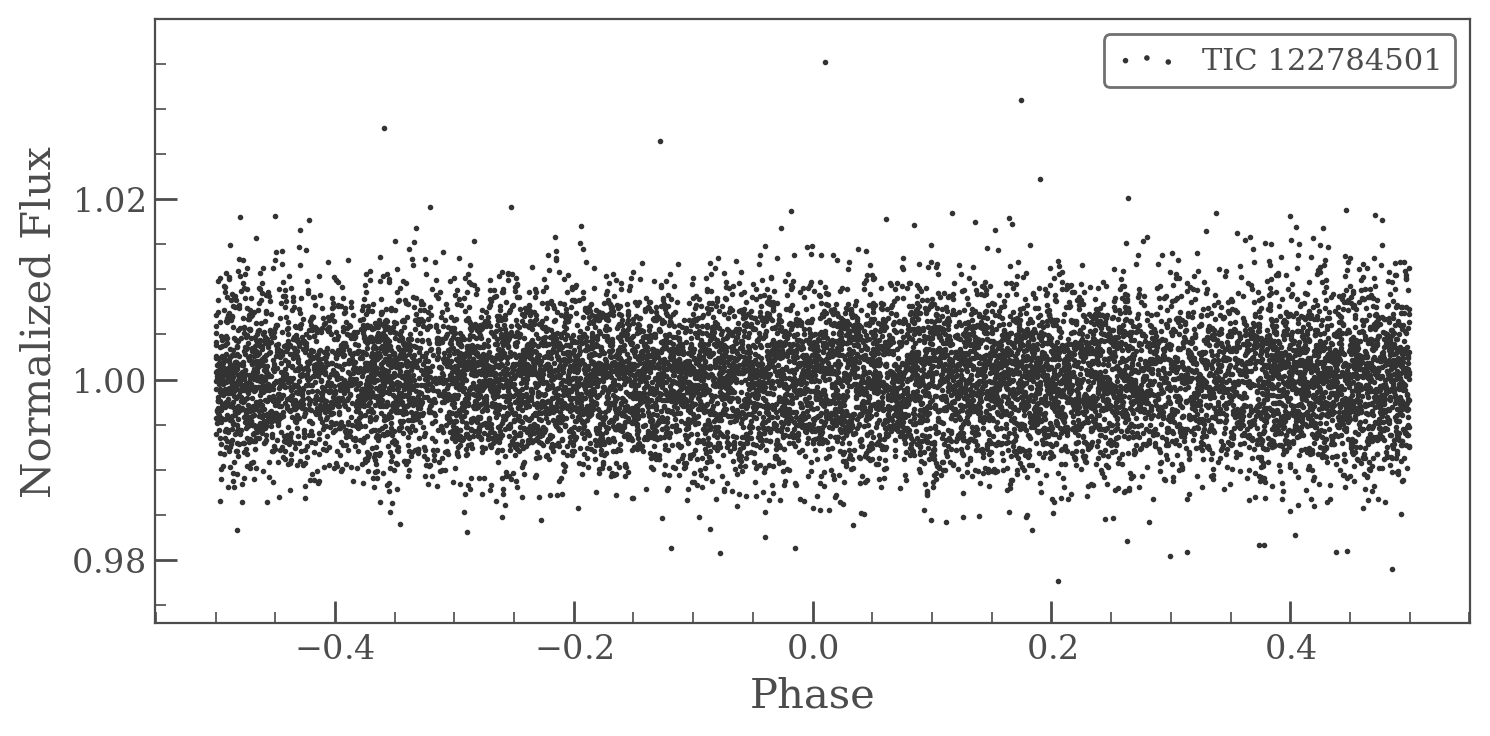

In [224]:
tess_folded = tess_lc.flatten().fold(period)
tess_folded.scatter()

In [229]:
row['GAIA_PARALLAX']

4.2728214

In [231]:
(1.7*u.arcsec * 245*u.pc).to(u.pc, u.dimensionless_angles()).to(u.au)

<Quantity 416.5 AU>

In [197]:
row['RA', 'DEC']

RA,DEC
float64,float64
291.048799,36.839882
